In [ ]:
using Oceananigans

grid = RectilinearGrid(size = (128, 128),
                       x = (0, 2π),
                       y = (0, 2π),
                       topology = (Periodic, Periodic, Flat))

model = NonhydrostaticModel(; grid, advection=WENO())

ϵ(x, y) = 2rand() - 1
set!(model, u=ϵ, v=ϵ)

simulation = Simulation(model; Δt=0.01, stop_iteration=100)
run!(simulation)

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (5.784 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (42.237 ms).
[ Info: Simulation is stopping after running for 2.440 seconds.
[ Info: Model iteration 100 equals or exceeds stop iteration 100.


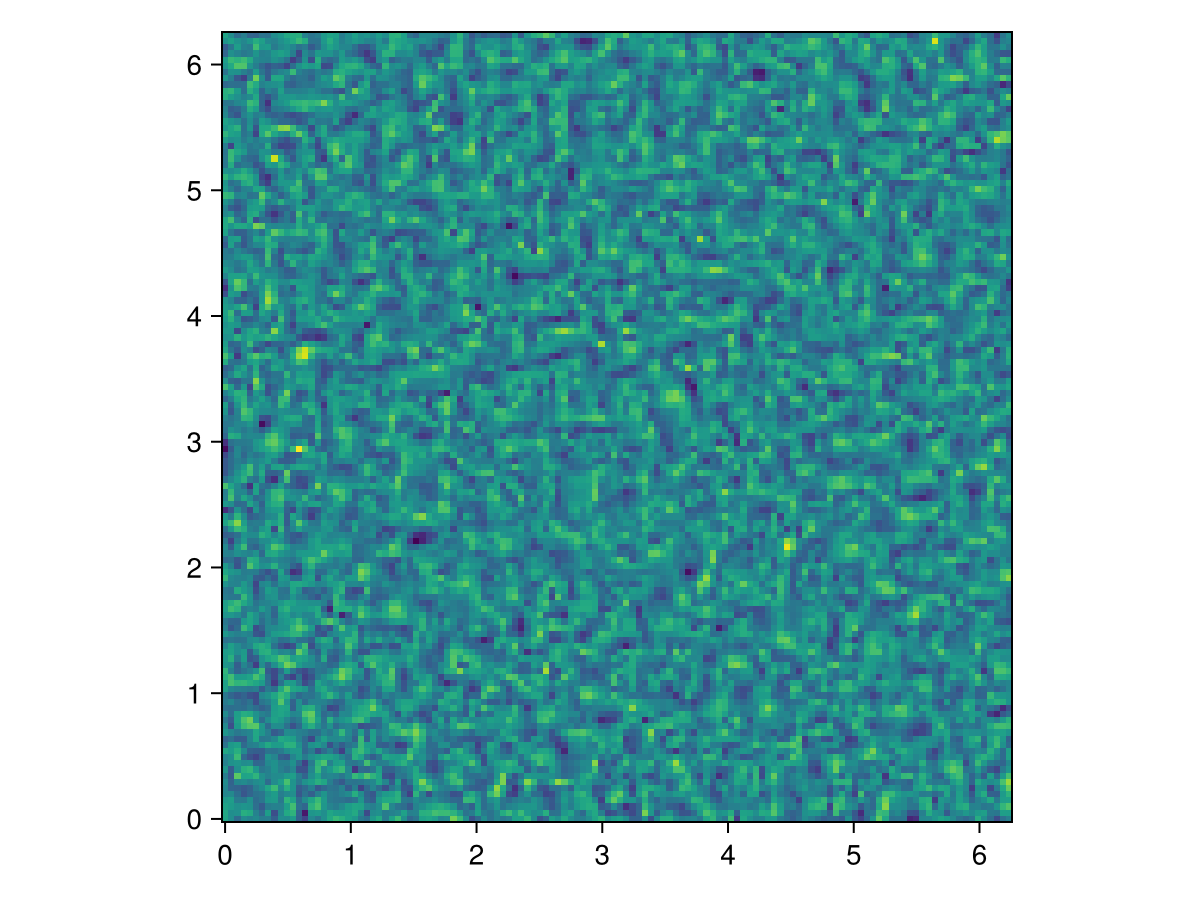

In [ ]:
using CairoMakie

u, v, w = model.velocities
ζ = Field(∂x(v) - ∂y(u))

heatmap(ζ, axis=(; aspect=1))

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (5.989 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (21.883 ms).
[ Info: Simulation is stopping after running for 8.482 seconds.
[ Info: Model iteration 500 equals or exceeds stop iteration 500.


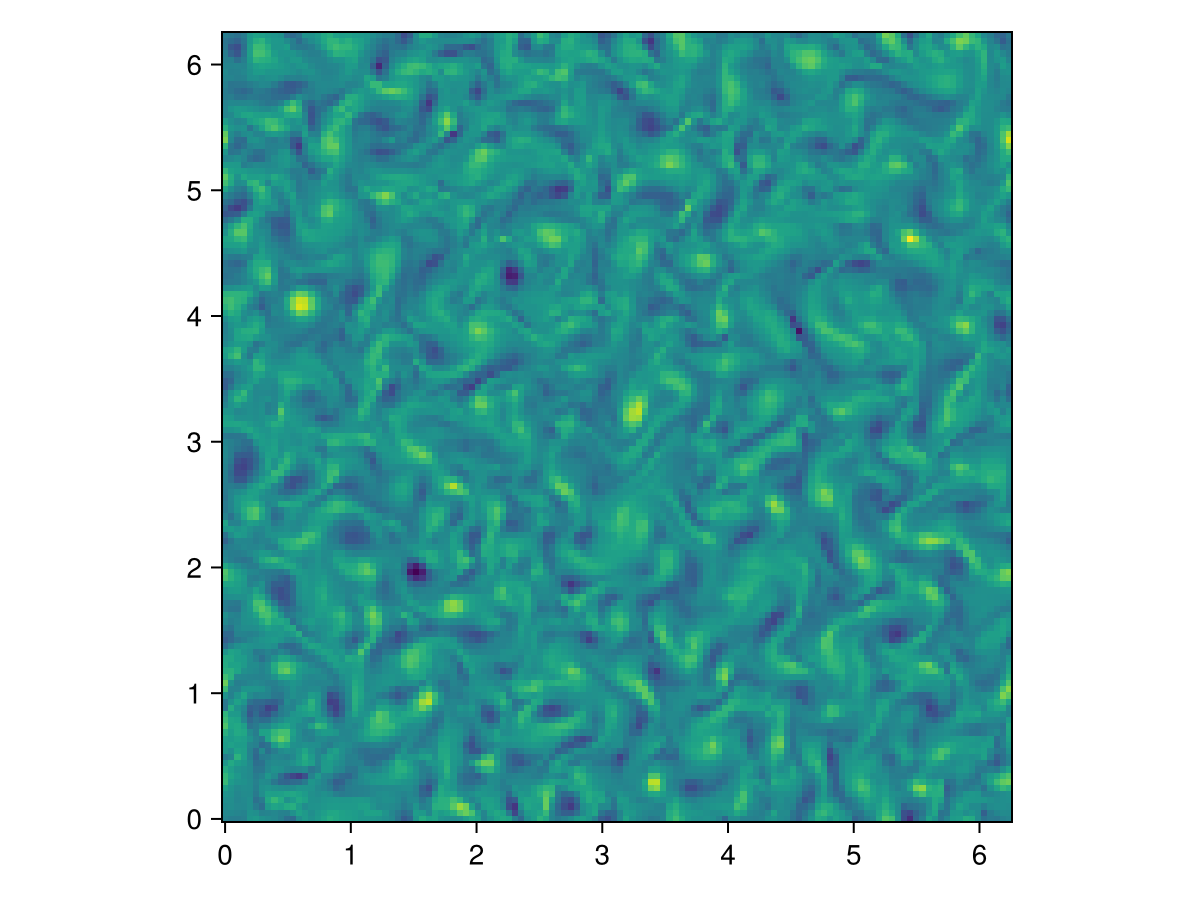

In [ ]:
simulation.stop_iteration += 400
run!(simulation)

heatmap(ζ, axis=(; aspect=1))

In [ ]:
using Oceananigans
using CairoMakie

grid = RectilinearGrid(CPU(),
                       size = (1024, 1024),
                       x = (-π, π),
                       y = (-π, π),
                       topology = (Periodic, Periodic, Flat))

model = NonhydrostaticModel(; grid, advection=WENO(), tracers=:c)

δ = 0.5
cᵢ(x, y) = exp(-(x^2 + y^2) / 2δ^2)
ϵ(x, y) = 2rand() - 1
set!(model, u=ϵ, v=ϵ, c=cᵢ)

simulation = Simulation(model; Δt=1e-3, stop_time=10)
conjure_time_step_wizard!(simulation, cfl=0.2, IterationInterval(10))
run!(simulation)

u, v, w = model.velocities
ζ = Field(∂x(v) - ∂y(u))

fig = Figure(size=(1200, 600))
axζ = Axis(fig[1, 1], aspect=1, title="vorticity")
axc = Axis(fig[1, 2], aspect=1, title="tracer")
heatmap!(axζ, ζ, colormap=:balance)
heatmap!(axc, model.tracers.c)
current_figure()

In [ ]:
using Oceananigans, CairoMakie

In [ ]:
grid = RectilinearGrid(size=128, z=(-0.5, 0.5), topology=(Flat, Flat, Bounded))

1×1×128 RectilinearGrid{Float64, Flat, Flat, Bounded} on CPU with 0×0×3 halo
├── Flat x                   
├── Flat y                   
└── Bounded  z ∈ [-0.5, 0.5] regularly spaced with Δz=0.0078125

In [ ]:
closure = ScalarDiffusivity(κ=1)

ScalarDiffusivity{ExplicitTimeDiscretization}(ν=0.0, κ=1.0)

In [ ]:
model = NonhydrostaticModel(; grid, closure, tracers=:T)

NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 1×1×128 RectilinearGrid{Float64, Flat, Flat, Bounded} on CPU with 0×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: Centered(order=2)
├── tracers: T
├── closure: ScalarDiffusivity{ExplicitTimeDiscretization}(ν=0.0, κ=(T=1.0,))
├── buoyancy: Nothing
└── coriolis: Nothing

In [ ]:
width = 0.1
initial_temperature(z) = exp(-z^2 / (2width^2))
set!(model, T=initial_temperature)

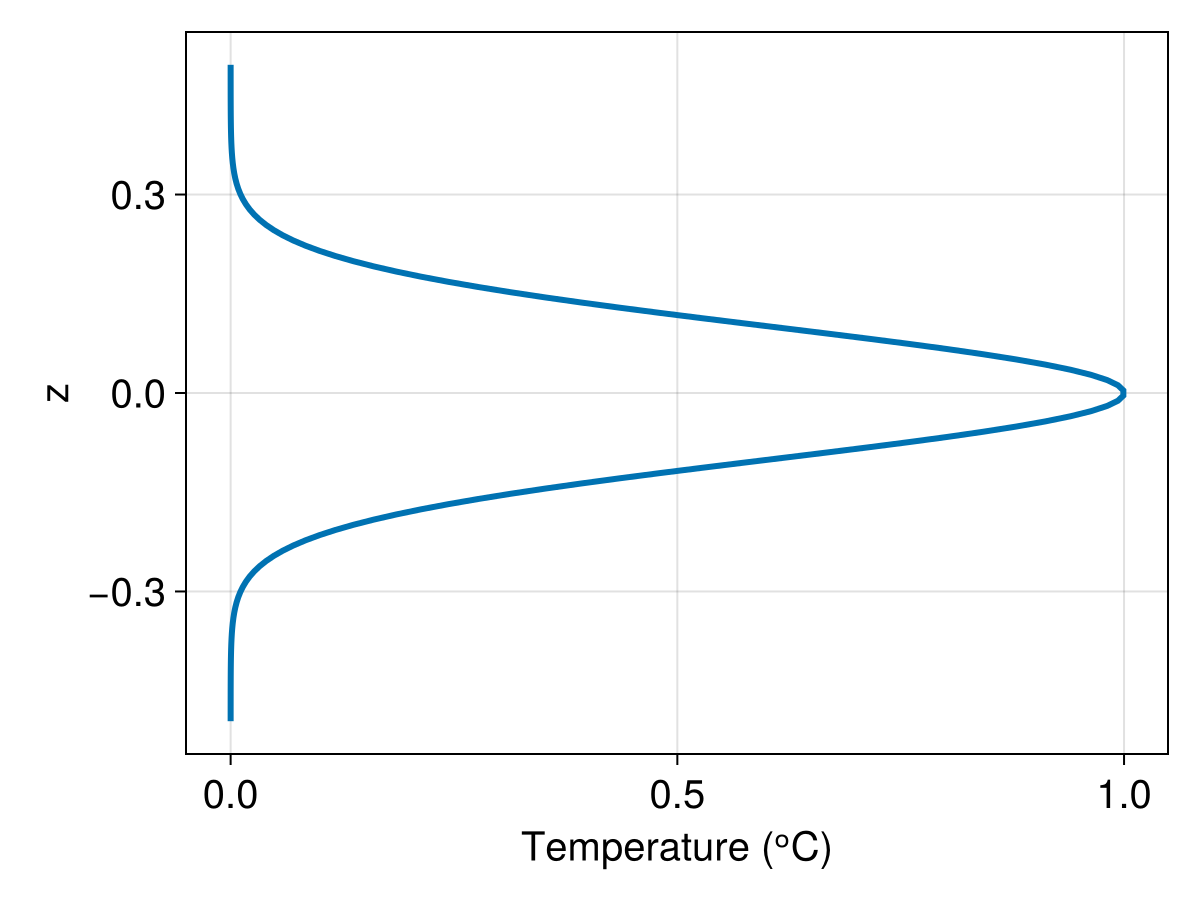

In [ ]:
set_theme!(Theme(fontsize = 20, linewidth=3))

fig = Figure()
axis = (xlabel = "Temperature (ᵒC)", ylabel = "z")
label = "t = 0"
lines(model.tracers.T; label, axis)

In [ ]:
# Time-scale for diffusion across a grid cell
min_Δz = minimum_zspacing(model.grid)
diffusion_time_scale = min_Δz^2 / model.closure.κ.T

simulation = Simulation(model, Δt = 0.1 * diffusion_time_scale, stop_iteration = 1000)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 6.104 μs
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: Inf days
├── Stop iteration: 1000.0
├── Wall time limit: Inf
├── Minimum relative step: 0.0
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => 4
│   ├── stop_iteration_exceeded => -
│   ├── wall_time_limit_exceeded => e
│   └── nan_checker => }
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [ ]:
run!(simulation)

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (4.310 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (6.168 seconds).
[ Info: Simulation is stopping after running for 14.314 seconds.
[ Info: Model iteration 1000 equals or exceeds stop iteration 1000.


In [ ]:
using Printf

label = @sprintf("t = %.3f", model.clock.time)
lines!(model.tracers.T; label)
axislegend()

Legend()

In [ ]:
simulation.output_writers[:temperature] =
    JLD2Writer(model, model.tracers,
               filename = "one_dimensional_diffusion.jld2",
               schedule=IterationInterval(100),
               overwrite_existing = true)

JLD2Writer scheduled on IterationInterval(100):
├── filepath: one_dimensional_diffusion.jld2
├── 1 outputs: T
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
├── file_splitting: NoFileSplitting
└── file size: 22.5 KiB

In [ ]:
simulation.stop_iteration += 10000
run!(simulation)

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (61.471 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (2.531 ms).
[ Info: Simulation is stopping after running for 22.326 seconds.
[ Info: Model iteration 11000 equals or exceeds stop iteration 11000.


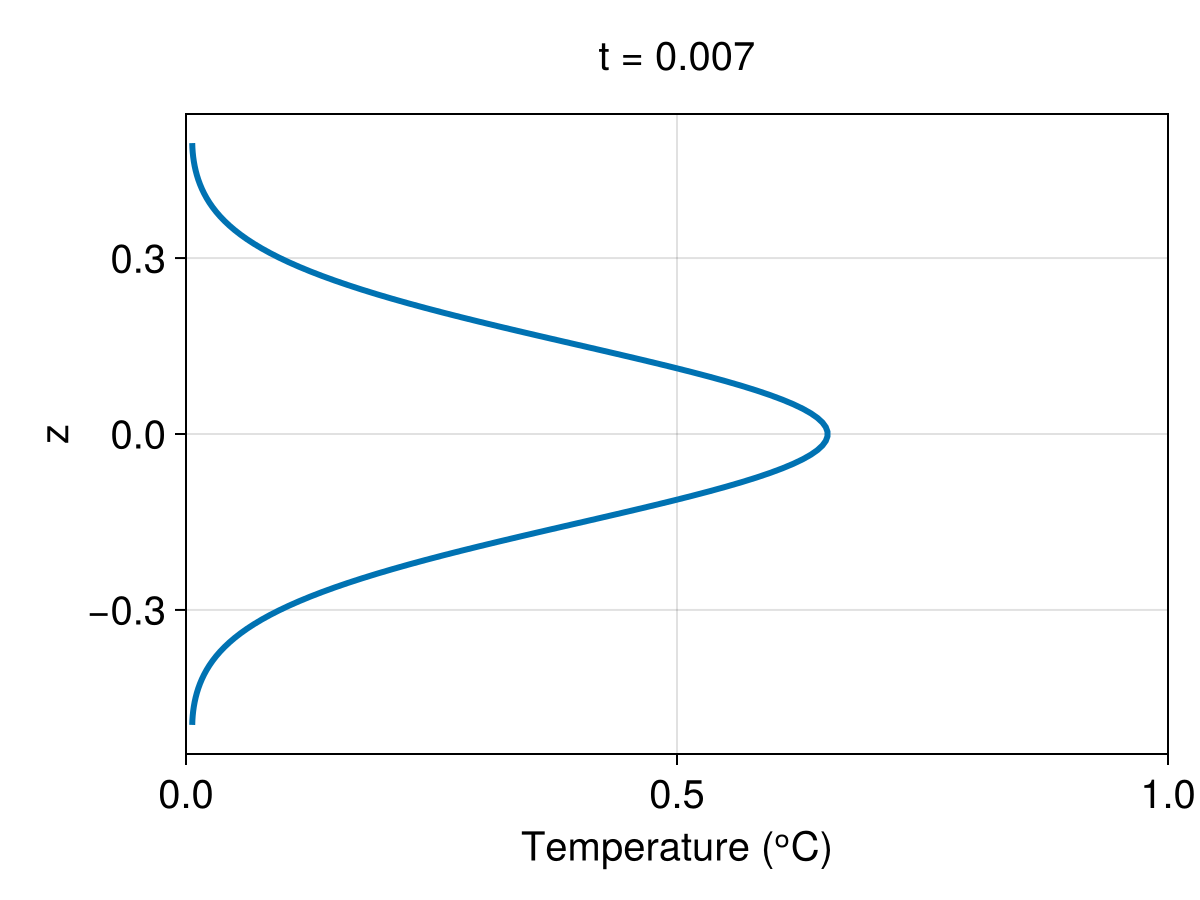

In [ ]:
T_timeseries = FieldTimeSeries("one_dimensional_diffusion.jld2", "T")
times = T_timeseries.times

fig = Figure()
ax = Axis(fig[2, 1]; xlabel = "Temperature (ᵒC)", ylabel = "z")
xlims!(ax, 0, 1)

n = Observable(1)

T = @lift T_timeseries[$n]
lines!(T)

label = @lift "t = " * string(round(times[$n], digits=3))
Label(fig[1, 1], label, tellwidth=false)

fig

In [ ]:
frames = 1:length(times)

@info "Making an animation..."

record(fig, "one_dimensional_diffusion.mp4", frames, framerate=24) do i
    n[] = i
end

[ Info: Making an animation...


"one_dimensional_diffusion.mp4"